## Least-sqaured regression

### Imports

In [401]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-ticks")
from numpy.random import randn

### Values

In [402]:
n = 200 # Number of points
sigma = 2
sigma2 = 2*sigma**2
lam = 0.000001

# Approximation parameters
m = 30
w = randn(m) / sigma
b = np.random.rand(m)*2*np.pi

# Example functions
x = randn(n)/2
y=np.cos(x) + randn(n) # randn(n) is noise

x_sort = np.sort(x)

### Gaussian kernel

In [403]:
def k_gauss(x, z): 
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def K_gauss(x, y, n):
    Kxy = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Kxy[i, j] = k_gauss(x[i], y[j])
    return Kxy

#### Alpha

In [404]:
def alpha_gauss(x, y, n):
    K = K_gauss(x, x, n)
    return np.linalg.inv(K + lam*np.eye(n)) @ y

alpha_ = alpha_gauss(x, y, n)

#### Estimated function

In [405]:
def function_gauss(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss(x[j], x_sort[i])
            f[i] = sum
    return f

func = function_gauss(x, n, alpha_)

#### Plot

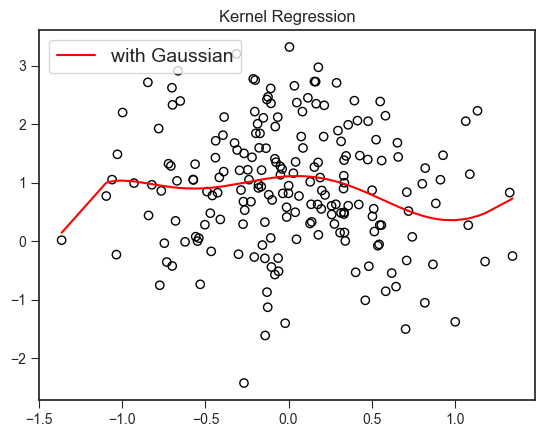

In [406]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func, c="r", label="with Gaussian")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

## Random Fourier Features

### Approximation 1

In [407]:
# Feature vector
def psi(x, w, b):
    return np.sqrt(2)*np.cos(w*x + b)

def k_approx1(x_i, z_i, w, b, m):
    return 1/m * np.sum(psi(x_i, w, b) * psi(z_i, w, b))

# Not in use
def K_approx1(x, z, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        for j in range(m):
            K[i, j] = k_approx1(x[i], z[j], w, b, m)
    return K

K_ = K_approx1(x, x, w, b, m)

#### Alpha

In [408]:
def alpha_approx1(x, y, lam, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        K[i, :] = psi(x[i], w, b)
    return np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y

alpha_approx = alpha_approx1(x, y, lam, w, b, m)

#### Estimated function

In [409]:
def function_approx1(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*psi(x_sort[i], w, b))
    return f

func_approx1 = function_approx1(x, n, alpha_approx)

#### Plot

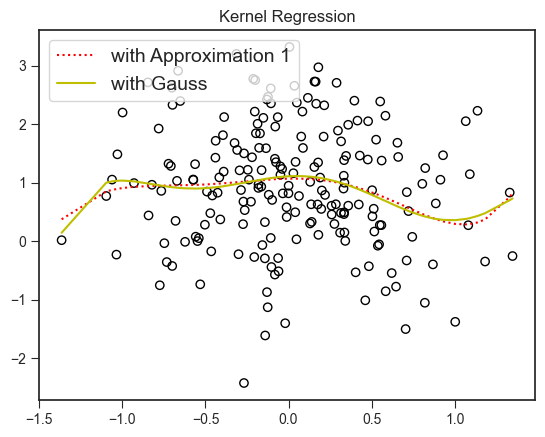

In [410]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

### Approximation 2

In [411]:
def psi_cos(x, w, m):
    return 1/np.sqrt(m) * np.cos(w*x)

def psi_sin(x, w, m):
    return 1/np.sqrt(m) * np.sin(w*x)

def k_approx2(x, y, w, m):
    return np.sum(psi_cos(x, w, m)*psi_cos(y, w, m)) + np.sum(psi_cos(x, w, m)*psi_cos(y, w, m))

# Not in use
def K_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m): 
            K[i, j] = k_approx2(x, y, w, m)
    return K

### Alpha

In [412]:
def alpha_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        K[i, :] = psi_cos(x[i], w, m) + psi_sin(x[i], w, m)
    alpha = np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y
    return alpha

alpha_2 = alpha_approx2(x, y, w, n, m)

#### Estimated function

In [413]:
def function_approx2(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*(psi_cos(x_sort[i], w, m) + psi_sin(x_sort[i], w, m)))
    return f

func_approx2 = function_approx2(x, n, alpha_2)

#### Plot

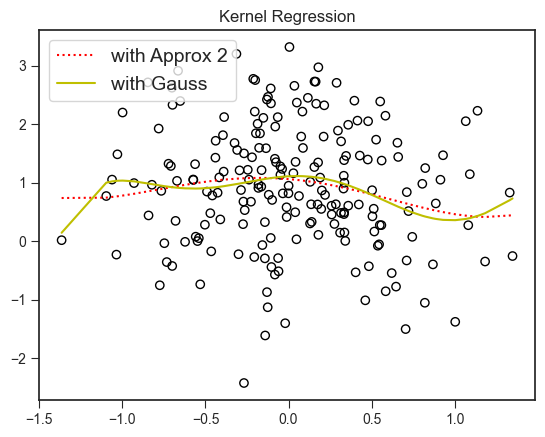

In [414]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approx 2", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

## All plots

In [ ]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approximation 2", ls = ":")
plt.plot(x_sort, func_approx1, c="b", label="with Approximation 1", ls = "--")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()